In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from abc import abstractmethod

In [18]:
OUTPUT_PATH = 'output/'
INPUT_PATH = 'dataset/'
BASE_FILE_NAME='btcusdt'
# TIME_FRAMES=['1h','3m','5m','15m','30m']
TIME_FRAMES=['30m']

SIGNALS = [-1,0,1]
PRICE_TYPE = ['open','close','high','low']

TIMEFRAME="30m"
PRICE_TYPE="close"

In [19]:
class PrVO:
    def __init__(self,open:float,high:float,low:float,close:float,volume:int,timeStamp:datetime) -> None:
        self.open = open
        self.high = high
        self.low = low
        self.close = close
        self.volume = volume
        self.timeStamp = timeStamp
        self.returns = (close - open)/open
        self.candle_color = 'GREEN' if self.close > self.open else 'RED'

    def __repr__(self) -> str:
        return f"Price-Volume : open={self.open}, high={self.high},low={self.low}, close={self.close}, volume={self.volume}, timeStamp={self.timeStamp}"
    
    def __str__(self) -> str:
        return f"Price-Volume : open={self.open}, high={self.high},low={self.low}, close={self.close}, volume={self.volume}, timeStamp={self.timeStamp}"
    
class Trade:
    
    def __init__(self) -> None:
        self.timeStamp = None
        self.signal = None
        self.price_type = None
    
    def execute(self,PrVo:PrVO ,signal:int,price_type:str) -> object:
        
        assert signal in SIGNALS, f"Invalid Signal {signal}"
        assert price_type in PRICE_TYPE, f"Invalid Price Type {price_type}"

        self.PrVo = PrVo
        self.signal = signal
        self.price_type = price_type
        return self
    
    def __str__(self) -> str:
        return f"{self.PrVo}\t{self.signal}\t {self.price_type}"
    

In [20]:
class TradingTerminal:

    def __init__(self) -> None:
        self.time=None
        self.PrVo=dict()
        self.cash_balance=1000
        self.tradeHistory=[]
        self.transaction_penalty=0.001
        # self.transaction_penalty=0
        self.transaction_cost=0

        for timeframe in TIME_FRAMES:
            self.readData(BASE_FILE_NAME+'_'+timeframe+'.xlsx')

    def readData(self,filepath:str):
        df=pd.read_excel(INPUT_PATH+filepath)
        
        data=[]
        for index,row in df.iterrows():
            data.append(PrVO(row['open'],row['high'],row['low'],row['close'],row['volume'],row['datetime']))

        data_timeframe=filepath.split('/')[-1].split('.')[0].split('_')[1]
        self.PrVo[data_timeframe]=np.array(data)
        
    def takeTrade(self,PrVo:PrVO,signal:int,price_type:str):
        assert signal in SIGNALS, f"Invalid Signal {signal}"
        assert price_type in PRICE_TYPE, f"Invalid Price Type {price_type}"

        trade=Trade().execute(PrVo,signal,price_type)
        self.tradeHistory.append(trade)

    def outputTradeHistory(self):
        file=open(OUTPUT_PATH+'trade_history.csv','w')

        file.write(f"Index,datetime,signals,open,high,low,close,volume\n")
        
        for index,trade in enumerate(self.tradeHistory):
            file.write(f"{index},{trade.PrVo.timeStamp},{trade.signal},{trade.PrVo.open},{trade.PrVo.high},{trade.PrVo.low},{trade.PrVo.close},{trade.PrVo.volume}\n")

    def setTime(self,time):
        self.time=time

    def resetEverything(self):
        self.time=None
        self.cash_balance=1000
        self.tradeHistory=[]
        self.transaction_cost=0

    def getPNL(self):

        equity_curve = np.array([self.cash_balance])

        coins_held=0
        
        for trade in self.tradeHistory:
            if trade.signal == 1:
                coins_held=(self.cash_balance*(1-self.transaction_penalty))/getattr(trade.PrVo,trade.price_type)
                self.transaction_cost+=self.cash_balance*(self.transaction_penalty)
                self.cash_balance=0
            elif trade.signal == -1:
                self.cash_balance=(1-self.transaction_penalty)*coins_held*getattr(trade.PrVo,trade.price_type)
                self.transaction_cost+=self.transaction_penalty*coins_held*getattr(trade.PrVo,trade.price_type)
                coins_held=0

            equity_curve=np.append(equity_curve,self.cash_balance+coins_held*getattr(trade.PrVo,trade.price_type))
        
        print(f"Final Cash Balance : {self.cash_balance}")
        print("Transaction Cost : ",self.transaction_cost)
        self.graphEquityCurve(equity_curve)

    def graphEquityCurve(self,equity_curve:[float]):

        print("Trades Taken : ",len(equity_curve))
        sns.set()
        plt.figure(figsize=(20, 10))
        plt.plot(equity_curve)
        plt.xlabel('Trades')
        plt.ylabel('Equity Curve')
        plt.show()
        
    def graphIndex(self,timeframe:str,price_type:str):
        assert price_type in PRICE_TYPE, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])
        plt.figure(figsize=(20, 10))
        plt.plot(prices)
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.show()

    def getSimpleMovingAverage(self, lag:int, timeframe:str, price_type:str):
        assert price_type in PRICE_TYPE, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"
        
        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])
        sma = np.convolve(prices, np.ones(lag) / lag, mode='valid')
        sma = np.concatenate([np.full(lag - 1, np.nan), sma])
        return sma

    def getExponentialMovingAverage(self, span:int, timeframe:str, price_type:str):
        assert price_type in PRICE_TYPE, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])
        ema = pd.Series(prices).ewm(span=span, adjust=False).mean().values
        return ema
    
    def getBollingerBands(self, lag:int, std_dev_factor:float, timeframe:str, price_type:str):
        assert price_type in PRICE_TYPE, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])
        sma = self.getExponentialMovingAverage(lag, timeframe, price_type)
        
        rolling_std = pd.Series(prices).rolling(window=lag).std().values

        upper_band = sma + std_dev_factor * rolling_std
        lower_band = sma - std_dev_factor * rolling_std

        return (upper_band, sma, lower_band)

        # WORKING INTERVAL

    def calculateRSI(self, period:int, timeframe:str, price_type:str):
        assert price_type in PRICE_TYPE, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])

        price_changes = np.diff(prices)
        gains = np.where(price_changes > 0, price_changes, 0)
        losses = np.where(price_changes < 0, -price_changes, 0)
        avg_gain = np.mean(gains[:period])
        avg_loss = np.mean(losses[:period])
        rsi_values = np.zeros_like(prices)
        for i in range(period, len(prices)):
            gain = gains[i - 1] if price_changes[i - 1] > 0 else 0
            loss = losses[i - 1] if price_changes[i - 1] < 0 else 0

            avg_gain = (avg_gain * (period - 1) + gain) / period
            avg_loss = (avg_loss * (period - 1) + loss) / period

            rs = avg_gain / avg_loss if avg_loss != 0 else np.inf
            rsi_values[i] = 100 - (100 / (1 + rs))

        return rsi_values
    
    def calculateStochasticRSI(self, period:int, timeframe:str, price_type:str):
        assert price_type in PRICE_TYPE, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        rsi = self.calculateRSI(period, timeframe, price_type)
        rsi_max = pd.Series(rsi).rolling(window=period).max().values
        rsi_min = pd.Series(rsi).rolling(window=period).min().values
        stoch_rsi = (rsi - rsi_min) / (rsi_max - rsi_min+1)
        return stoch_rsi
    
    def calculateMACD(self, slow_period:int, fast_period:int, signal_period:int, timeframe:str, price_type:str):
        assert price_type in PRICE_TYPE, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])
        slow_ema = self.getExponentialMovingAverage(slow_period, timeframe, price_type)
        fast_ema = self.getExponentialMovingAverage(fast_period, timeframe, price_type)
        macd = fast_ema - slow_ema
        signal = self.getExponentialMovingAverage(signal_period, timeframe, price_type)
        return macd, signal
    

    # WORKING UNTIL ABOVE

    def calculateATR(self, period:int, timeframe:str):
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        curr_high = np.array([getattr(entry, "high") for entry in self.PrVo[timeframe]])
        curr_low = np.array([getattr(entry, "low") for entry in self.PrVo[timeframe]])

        prev_high = np.roll(curr_high, 1)
        prev_low = np.roll(curr_low, 1)
        prev_high[0] = np.nan
        prev_low[0] = np.nan

        tr = np.maximum(curr_high - curr_low, abs(curr_high - prev_low), abs(curr_low - prev_low))

        atr = np.zeros_like(tr)
        atr[period - 1] = np.mean(tr[:period])

        for i in range(period, len(tr)):
            atr[i] = (atr[i - 1] * (period - 1) + tr[i]) / period

        return atr

    def calculateSuperTrend(self, period, multiplier, timeframe, price_type):
        assert price_type in PRICE_TYPE, f"Invalid Price Type {price_type}"
        assert timeframe in TIME_FRAMES, f"Invalid Time Frame {timeframe}"

        prices = np.array([getattr(entry, price_type) for entry in self.PrVo[timeframe]])
        atr = self.calculateATR(period, timeframe, price_type)

        upper_band = prices + multiplier * atr
        lower_band = prices - multiplier * atr

        uptrend = True
        supertrend = np.zeros_like(prices)

        for i in range(period, len(prices)):
            if prices[i] > upper_band[i - 1] and uptrend:
                supertrend[i] = lower_band[i]
                uptrend = False
            elif prices[i] < lower_band[i - 1] and not uptrend:
                supertrend[i] = upper_band[i]
                uptrend = True
            else:
                supertrend[i] = supertrend[i - 1] if uptrend else supertrend[i - 1]

        return supertrend


In [21]:
class Strategy:
    def __init__(self,TradingTerminal:TradingTerminal) -> None:
        self.terminal=TradingTerminal

    @abstractmethod
    def run(self, *args):
        pass

In [62]:
class Strategy1(Strategy):

    def __init__(self,TradingTerminal) -> None:
        super().__init__(TradingTerminal)

    def run(self,lag1:int,lag2:int,price_type:str,timeframe:str):
        assert price_type in PRICE_TYPE, f"Invalid Price Type {price_type}"
        assert lag1>lag2, f"Invalid Lag {lag1} {lag2}"
        assert timeframe in self.terminal.PrVo.keys(), f"Invalid Timeframe {timeframe}"

        self.terminal.resetEverything()
        PrVo=self.terminal.PrVo[timeframe]

        ema1=self.terminal.getSimpleMovingAverage(lag1,timeframe,price_type)
        ema2=self.terminal.getSimpleMovingAverage(lag2,timeframe,price_type)
        rsi=self.terminal.calculateRSI(lag2,timeframe,price_type)
        moving_average_crossover_factor=1.025
        has_purchased = False
                
        for idx, (val1, val2) in enumerate(zip(ema1, ema2)):
            if ( (val1 >= moving_average_crossover_factor*val2) or rsi[idx]<=25 ) and not has_purchased:
                self.terminal.takeTrade(PrVo[idx], 1, price_type)
                has_purchased = True
            elif ( (val1 <= (2-moving_average_crossover_factor)*val2) or rsi[idx]>=75 ) and has_purchased:
                self.terminal.takeTrade(PrVo[idx], -1, price_type)
                has_purchased = False  

        if has_purchased:
            self.terminal.takeTrade(PrVo[-1], -1, price_type)    

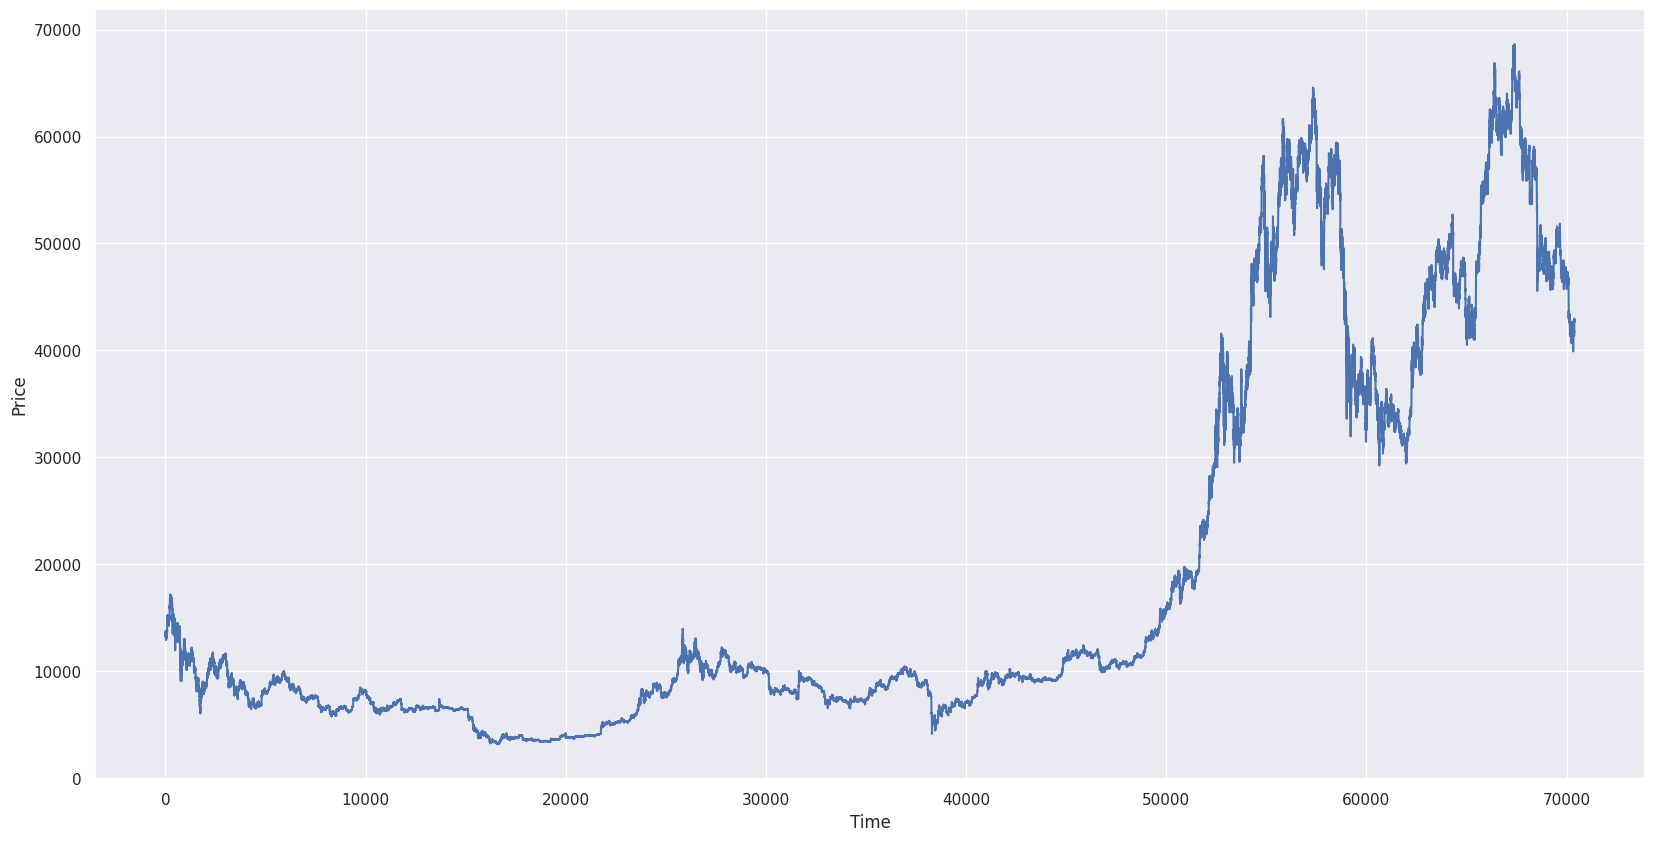

In [26]:
tt=TradingTerminal()
tt.graphIndex(TIMEFRAME,PRICE_TYPE)

Final Cash Balance : 1538.753984297383
Transaction Cost :  86.27188521716121
Trades Taken :  85


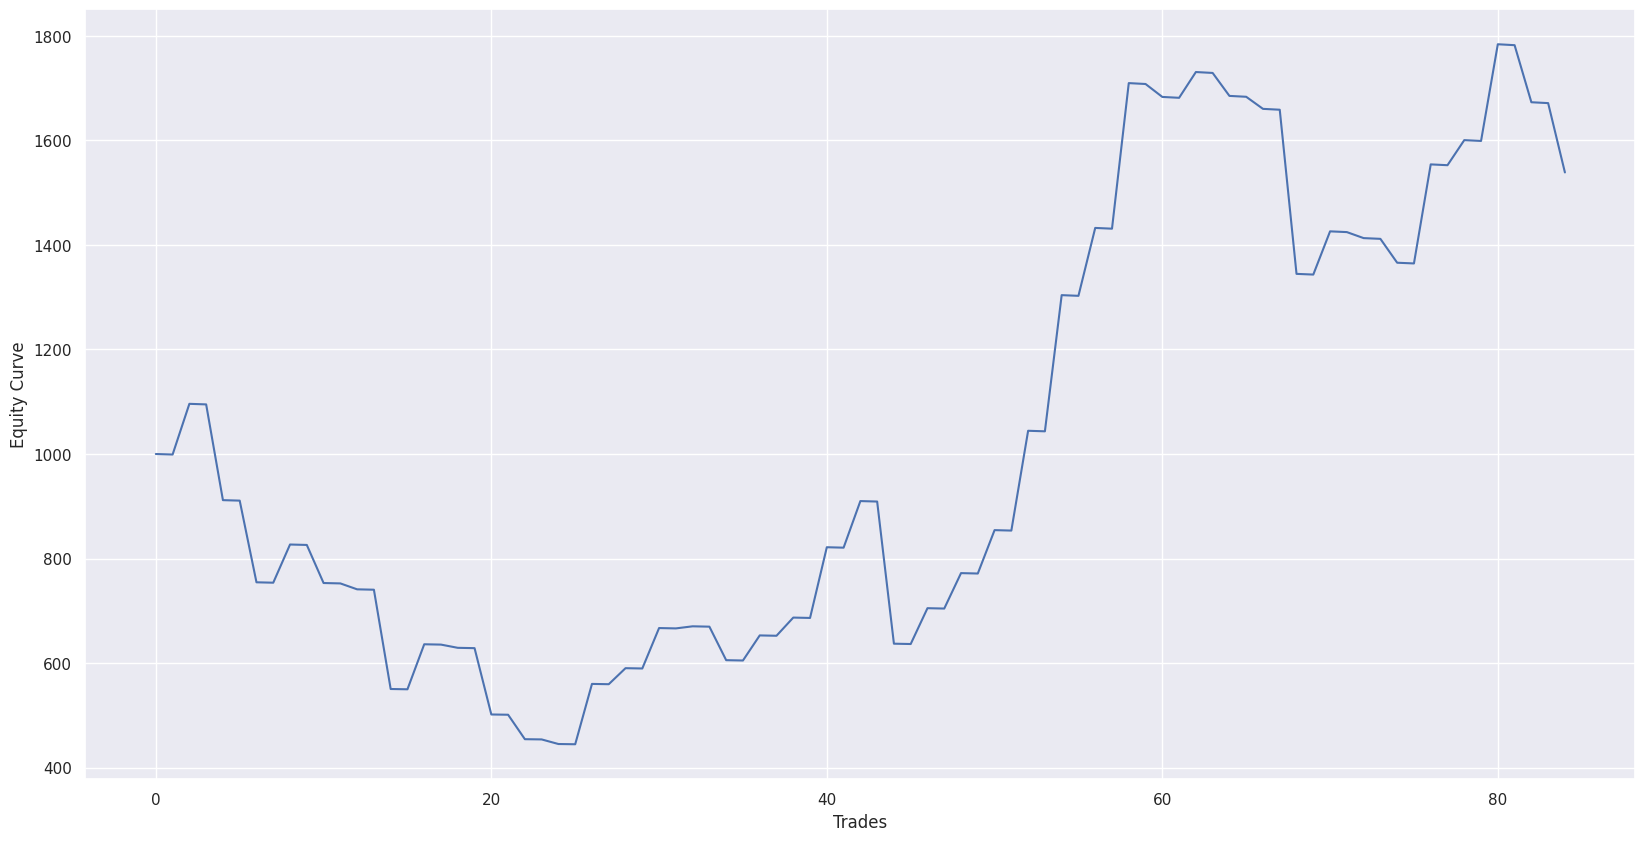

In [63]:
s1=Strategy1(tt)
s1.run(200,100,PRICE_TYPE,TIMEFRAME)
tt.outputTradeHistory()
tt.getPNL()